<font color = blue><font size = 6> 실험설명 </font></font><br>
Seasonality 한주기를 임의 설정한후 moving average를 주기마다 겹치지 않게 해보겠다(Stride를 조정하겠다는 의미)<br>
여기서는 Linear layer하나에 한개의 trend가 들어가게 된다<br>
이것을 하는 이유는 DLinear에서 Decompose를 할때 moving average 자체에 어느정도의 seasonallity가 포함돼 있는거 같기 때문에 이를 더 엄격하게 구분하기 위해서 이다 
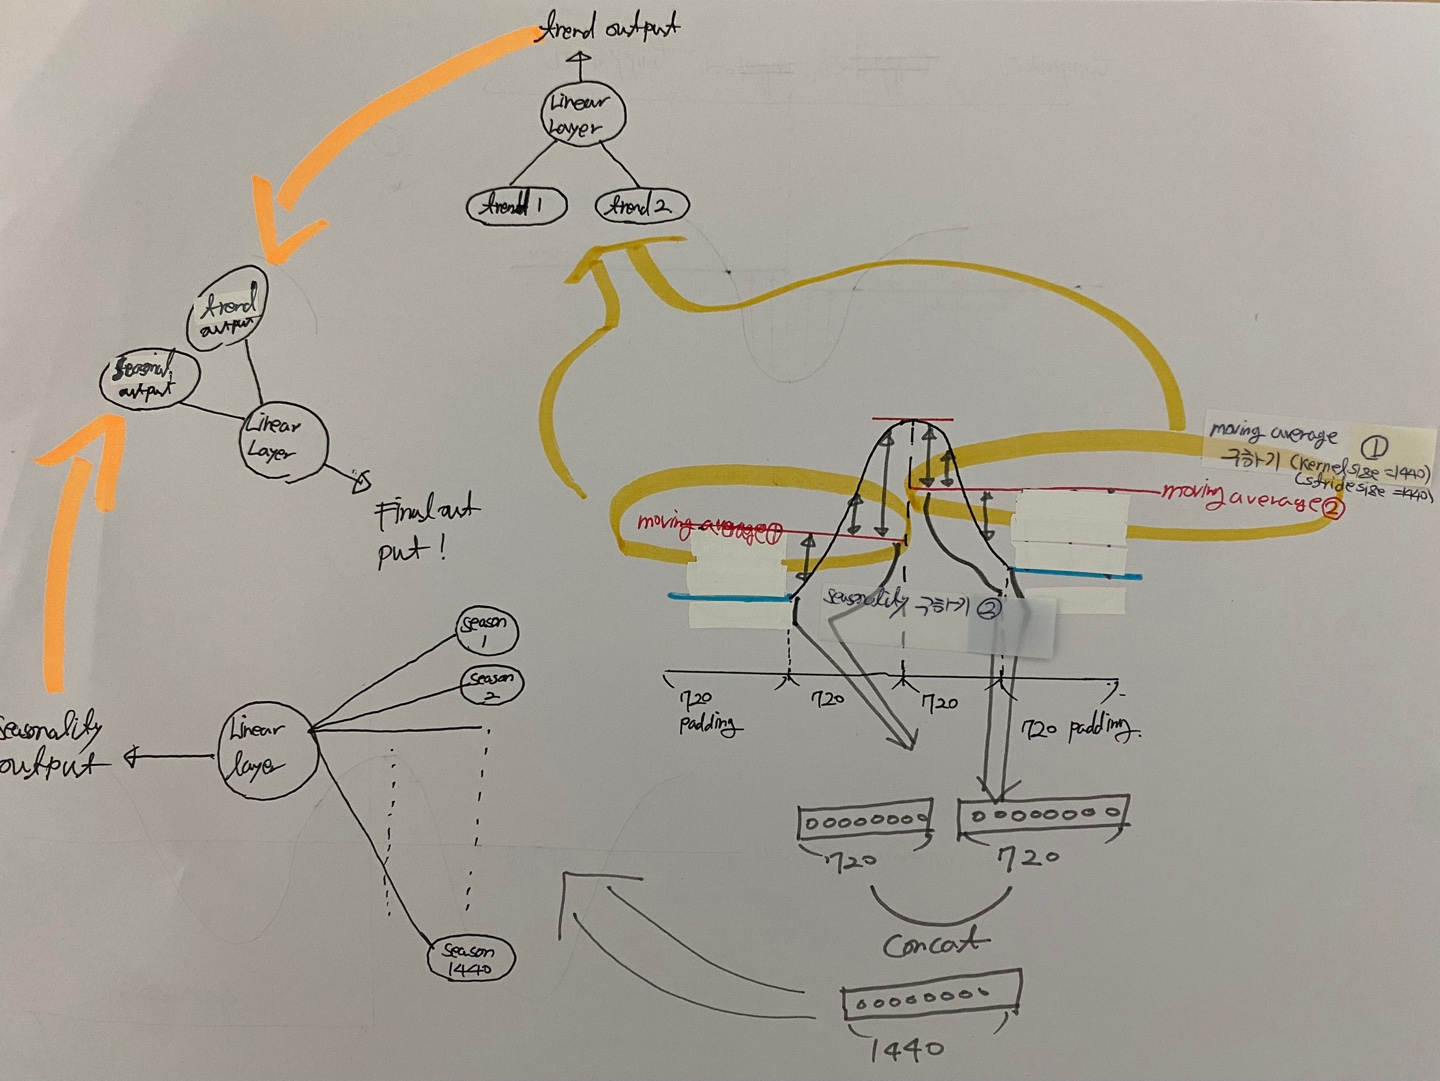

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,MAPE,RMSE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


<AxesSubplot: >

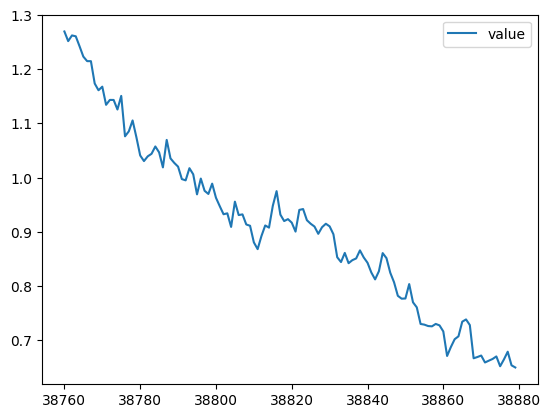

In [8]:
data[-120:].plot()

<AxesSubplot: >

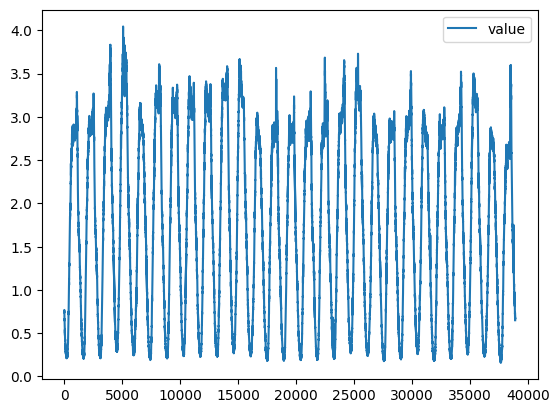

In [5]:
data.plot()

<AxesSubplot: >

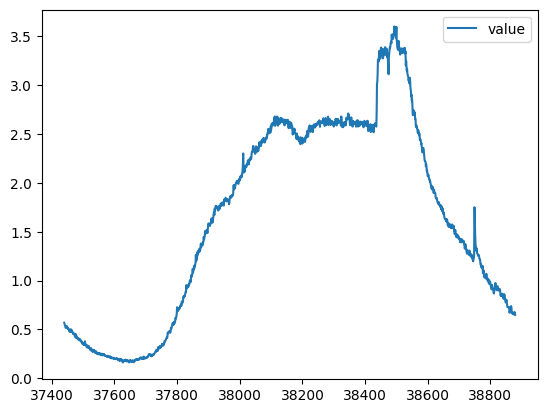

In [6]:
data[-3000:].plot() # 1일의 계절성이 있는것으로 판단된다

In [5]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel2/online-learning-DLinear']

In [6]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

[1,1,1] Size에서 [1,2,1] Size를 빼면 앞에꺼 원소 한개를 뒤에 원소 2개에 대응한다

In [7]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len//self.stride,self.pred_len)) # 이렇게 설정하면 현재 상황에선 Layer당 Unit이 1개
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(2,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x/div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [9]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_580049/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [12]:
torch.manual_seed(42)

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 76.20263410546974 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 48.47017061531718 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 26.47855271046099 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 11.213172320712205 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 6.221193124687201 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 6.054188483204061 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 5.910040889403712 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 5.770221837082802 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 5.678065035993244 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 5.619542707923299 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 5.566070384362288 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 5.520814944723109 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 5.484994367549294 %
Adjusting l

In [14]:
torch.manual_seed(42)

In [15]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 3.106102812460449 %
SMAPE 1.109804667019489 %
SMAPE 1.2850026756291868 %
SMAPE 0.26398982782984604 %
SMAPE 1.3532309487245584 %
SMAPE 0.60572746611615 %
SMAPE 0.4087496731426654 %
SMAPE 0.06426477742752468 %
SMAPE 1.3251889967195893 %
SMAPE 0.023636408694528654 %
SMAPE 0.33609252991846006 %
SMAPE 0.6548081558361218 %
SMAPE 1.9742235054882258 %
SMAPE 0.01971415861225978 %
SMAPE 0.04459183652443244 %
SMAPE 0.5907087259206492 %
SMAPE 0.15307986344851088 %
SMAPE 0.3446438758801378 %
SMAPE 1.889913082750809 %
SMAPE 0.30412743264787423 %
SMAPE 0.7083261550615134 %
SMAPE 0.013418627004966767 %
SMAPE 0.4033100340202509 %
SMAPE 0.015345037820679863 %
SMAPE 0.15968222234414498 %
SMAPE 0.8838483245478415 %
SMAPE 1.6140485489740966 %
SMAPE 0.05128698937096487 %
SMAPE 1.1380936756004303 %
SMAPE 1.9506374844104355 %
SMAPE 0.9999290931118595 %
SMAPE 1.355189995985711 %
SMAPE 0.8971247706609233 %
SMAPE 0.12805245940216992 %
SMAPE 0.16504726224820843 %
SMAPE 0.26952451186389226 %
SMAPE 1.07640549

SMAPE 1.5070784283852845 %
SMAPE 0.22494229167386945 %
SMAPE 0.08195622021958116 %
SMAPE 0.21486066905981716 %
SMAPE 0.9612586956791347 %
SMAPE 0.8428940861749652 %
SMAPE 0.028406826480932068 %
SMAPE 1.225154561019508 %
SMAPE 3.9293469887488754 %
SMAPE 1.9492875891217523 %
SMAPE 0.03936361578030301 %
SMAPE 0.5412213749086732 %
SMAPE 2.0336472509079613 %
SMAPE 0.10552003697739565 %
SMAPE 0.5065881553146028 %
SMAPE 0.3145652288267229 %
SMAPE 0.4021174227673328 %
SMAPE 1.3815597198013165 %
SMAPE 2.254465927459023 %
SMAPE 0.10444270848165614 %
SMAPE 0.05140278887040495 %
SMAPE 0.5427456800566688 %
SMAPE 0.6315141256254719 %
SMAPE 0.30318175789034285 %
SMAPE 1.0255525912580197 %
SMAPE 1.1016244804304733 %
SMAPE 0.045336870032315346 %
SMAPE 0.5966841089085051 %
SMAPE 0.82246862788611 %
SMAPE 0.9590365694093635 %
SMAPE 0.8105627007844306 %
SMAPE 0.024181835404618823 %
SMAPE 0.0392739828903359 %
SMAPE 0.3080761833118686 %
SMAPE 2.507952846099215 %
SMAPE 1.795164280103563 %
SMAPE 1.278237883274

SMAPE 0.30765038436038594 %
SMAPE 1.0229002102278173 %
SMAPE 0.4701844257706398 %
SMAPE 0.14030454304198514 %
SMAPE 0.0028434651381843423 %
SMAPE 0.015012745808519414 %
SMAPE 0.2902214723180805 %
SMAPE 2.11265663895756 %
SMAPE 0.042475935312495494 %
SMAPE 0.954726134194061 %
SMAPE 0.027552478562483888 %
SMAPE 0.04949084930512981 %
SMAPE 2.223144323565066 %
SMAPE 0.35980036911860225 %
SMAPE 0.11700897086697637 %
SMAPE 0.14738431291334564 %
SMAPE 0.9340581188444047 %
SMAPE 0.01394302116478485 %
SMAPE 0.3070994156596498 %
SMAPE 0.8352003172039985 %
SMAPE 1.6662082830443978 %
SMAPE 0.013047390010285655 %
SMAPE 0.08861612479483938 %
SMAPE 0.07226168848194447 %
SMAPE 0.06734271390826052 %
SMAPE 2.1882496308535337 %
SMAPE 1.597986651584506 %
SMAPE 0.014445746465582943 %
SMAPE 0.3383454432905637 %
SMAPE 0.03402209263038003 %
SMAPE 0.5726066542720218 %
SMAPE 0.11174719088461417 %
SMAPE 3.028616324067116 %
SMAPE 0.08196243139514081 %
SMAPE 0.05485867437752746 %
SMAPE 0.9515822401735932 %
SMAPE 0

SMAPE 0.0862476505614751 %
SMAPE 0.5114228069881079 %
SMAPE 0.6026883964677836 %
SMAPE 0.005197537076895742 %
SMAPE 0.22250266239780106 %
SMAPE 0.9106519322376698 %
SMAPE 1.015660116681829 %
SMAPE 0.3028081726588425 %
SMAPE 0.1700190198225755 %
SMAPE 0.8402341397013515 %
SMAPE 2.317610552534461 %
SMAPE 0.3120116969148512 %
SMAPE 1.1546304351650178 %
SMAPE 0.02082947380540645 %
SMAPE 0.18802012783407918 %
SMAPE 0.1083462680253433 %
SMAPE 1.0317450030706823 %
SMAPE 1.724455565214157 %
SMAPE 1.500082268047663 %
SMAPE 1.4193529370240867 %
SMAPE 0.32555064444386517 %
SMAPE 0.001908942229619015 %
SMAPE 0.3182821680397865 %
SMAPE 0.14375682486729602 %
SMAPE 0.09610950961098297 %
SMAPE 0.1737067526177043 %
SMAPE 1.4441471518948674 %
SMAPE 1.0691334544681013 %
SMAPE 1.2518188208341599 %
SMAPE 0.5889898763562087 %
SMAPE 0.15642674453033578 %
SMAPE 0.10961284813151906 %
SMAPE 0.021229148574121837 %
SMAPE 0.24328658247213752 %
SMAPE 0.0307915063085602 %
SMAPE 0.36384434049523406 %
SMAPE 0.08087778

SMAPE 0.03903540082410473 %
SMAPE 1.1705682946339948 %
SMAPE 2.0752921402454376 %
SMAPE 0.8856672883703142 %
SMAPE 0.13039341142030025 %
SMAPE 0.5343630985389609 %
SMAPE 0.853523088801012 %
SMAPE 0.6602822768663827 %
SMAPE 0.08912557172716618 %
SMAPE 0.011594162173423683 %
SMAPE 0.6147095563183029 %
SMAPE 1.0603835896472447 %
SMAPE 1.7524225977249441 %
SMAPE 2.2496174992993474 %
SMAPE 0.7010045340648503 %
SMAPE 0.08896266472243042 %
SMAPE 0.19595196700424822 %
SMAPE 0.13245982643388743 %
SMAPE 0.010311459355648367 %
SMAPE 0.17777253904773715 %
SMAPE 1.5067619484616444 %
SMAPE 0.7681420062499456 %
SMAPE 0.05399132198400025 %
SMAPE 0.23764449676332333 %
SMAPE 1.2952976943925023 %
SMAPE 0.8185654164099104 %
SMAPE 2.075281532946974 %
SMAPE 2.1556937536224723 %
SMAPE 3.6124974135309453 %
SMAPE 0.885787191145937 %
SMAPE 0.5073538613105484 %
SMAPE 1.6320390733890233 %
SMAPE 0.016362387483241037 %
SMAPE 1.0484216277254745 %
SMAPE 2.1563200624659657 %
SMAPE 0.29897010233025867 %
SMAPE 0.9374716

SMAPE 0.1634437334132599 %
SMAPE 0.23876774927316544 %
SMAPE 0.23114574231135523 %
SMAPE 0.08091620144114131 %
SMAPE 0.6928501580441662 %
SMAPE 0.07488078902214568 %
SMAPE 1.471581460260495 %
SMAPE 0.2090528151225044 %
SMAPE 0.07531026638525873 %
SMAPE 0.19834430496678124 %
SMAPE 0.565613531017334 %
SMAPE 0.7453821369481375 %
SMAPE 1.9421813259541523 %
SMAPE 3.7241729320958252 %
SMAPE 5.148013094440103 %
SMAPE 0.06864434606990244 %
SMAPE 1.1332414909593354 %
SMAPE 3.7455419674224686 %
SMAPE 0.21419849820330225 %
SMAPE 0.08445426660637168 %
SMAPE 0.15032301966539308 %
SMAPE 0.13731453723096365 %
SMAPE 0.1524443245261864 %
SMAPE 0.4095950120990892 %
SMAPE 0.05483811747035361 %
SMAPE 0.5368878223362259 %
SMAPE 1.770612188753148 %
SMAPE 1.9844839538764063 %
SMAPE 3.32094390988641 %
SMAPE 0.3395226198621657 %
SMAPE 0.21740133732691902 %
SMAPE 0.051208487621806846 %
SMAPE 0.7480590568189882 %
SMAPE 0.4055933133300869 %
SMAPE 0.5010872589891733 %
SMAPE 4.022579592012335 %
SMAPE 0.711172361574

SMAPE 0.1482891435782676 %
SMAPE 0.2516103789716908 %
SMAPE 0.5734245697725555 %
SMAPE 0.5553177538204181 %
SMAPE 2.2514246475329855 %
SMAPE 0.11649605529964902 %
SMAPE 0.2062380239585764 %
SMAPE 0.9770703701615275 %
SMAPE 0.4219603064284456 %
SMAPE 0.4939185786947746 %
SMAPE 1.1817985050643074 %
SMAPE 0.7947536071678769 %
SMAPE 0.2925747252538713 %
SMAPE 0.03944821285949729 %
SMAPE 0.08613302342564566 %
SMAPE 0.2225560371625761 %
SMAPE 1.2637461913063817 %
SMAPE 0.8928221771930112 %
SMAPE 0.5887868205231825 %
SMAPE 3.4970845345960697 %
SMAPE 1.7834131886065734 %
SMAPE 0.0976324954563097 %
SMAPE 0.642611266401218 %
SMAPE 0.30333683661956456 %
SMAPE 0.41551054535284493 %
SMAPE 0.18686246916831806 %
SMAPE 0.27025235875316866 %
SMAPE 0.08337426342313847 %
SMAPE 0.30975848456273525 %
SMAPE 0.6506423466380511 %
SMAPE 0.285238018403561 %
SMAPE 0.024986302037973477 %
SMAPE 0.22018439518609514 %
SMAPE 0.023138031980352025 %
SMAPE 0.14774349055358016 %
SMAPE 0.052183641257215634 %
SMAPE 0.40180

SMAPE 0.45273244017334946 %
SMAPE 0.18514633011983506 %
SMAPE 0.7399068110717053 %
SMAPE 0.3381123389881395 %
SMAPE 0.1687351515647606 %
SMAPE 0.013543833163822683 %
SMAPE 0.1642437373093344 %
SMAPE 0.19281678465631558 %
SMAPE 0.0894323105728958 %
SMAPE 0.03258190166980057 %
SMAPE 0.18871918206286864 %
SMAPE 0.8017147262016806 %
SMAPE 0.12714416046514998 %
SMAPE 0.010277267520734767 %
SMAPE 0.05669413449516014 %
SMAPE 0.05906735822190967 %
SMAPE 0.028376245693607416 %
SMAPE 0.015211827106782039 %
SMAPE 0.0299458280142062 %
SMAPE 0.01756102211756172 %
SMAPE 0.06332623367870838 %
SMAPE 0.7420095920697349 %
SMAPE 0.4488955961769534 %
SMAPE 0.049762226679305854 %
SMAPE 0.21566771089840134 %
SMAPE 0.2326773403345328 %
SMAPE 0.16320983202149364 %
SMAPE 0.052698362601176996 %
SMAPE 0.11291714292201505 %
SMAPE 0.06608910672639468 %
SMAPE 0.07359366675234469 %
SMAPE 0.2718693659151654 %
SMAPE 0.7829898667951055 %
SMAPE 0.7050541633084322 %
SMAPE 0.409786818541761 %
SMAPE 0.026907662406188138 %


SMAPE 0.16466596843110892 %
SMAPE 0.02388183630387175 %
SMAPE 0.6534213006252685 %
SMAPE 0.9643491289098164 %
SMAPE 0.18785091106087748 %
SMAPE 0.10558866219798801 %
SMAPE 0.08252868198178476 %
SMAPE 0.0408644450213842 %
SMAPE 0.19746383983601845 %
SMAPE 0.06124403119383714 %
SMAPE 0.007275472215837908 %
SMAPE 0.06814064715291579 %
SMAPE 0.010570063405907604 %
SMAPE 0.4081057236695642 %
SMAPE 0.6406421747624336 %
SMAPE 0.2221644491881989 %
SMAPE 0.2823883898281565 %
SMAPE 0.13052003620941832 %
SMAPE 0.2809025583987932 %
SMAPE 0.09591883021403191 %
SMAPE 1.0899270456563954 %
SMAPE 1.1234021706331987 %
SMAPE 0.03299930106851434 %
SMAPE 0.5754553407277854 %
SMAPE 0.08869195860611967 %
SMAPE 0.13531094911687092 %
SMAPE 0.10144019760969059 %
SMAPE 0.1133362014015802 %
SMAPE 0.0374553933684183 %
SMAPE 0.06617978127155766 %
SMAPE 0.17083777448260662 %
SMAPE 0.4297604151229279 %
SMAPE 0.05905469056642687 %
SMAPE 0.04488977299365615 %
SMAPE 0.1824446105277957 %
SMAPE 0.05300494860048843 %
SMAPE

SMAPE 0.28695433739949294 %
SMAPE 0.035401472956891666 %
SMAPE 0.047748858247814496 %
SMAPE 0.04569516571427812 %
SMAPE 0.03599675291798121 %
SMAPE 0.0659768293987355 %
SMAPE 0.1347053645822598 %
SMAPE 0.24417936353893308 %
SMAPE 0.06928752167527819 %
SMAPE 0.10352666409551146 %
SMAPE 0.05079540229604618 %
SMAPE 0.06675505020518813 %
SMAPE 0.22959135843711923 %
SMAPE 0.35285456154269923 %
SMAPE 0.03868921808793857 %
SMAPE 0.7007892931542301 %
SMAPE 0.16833086468795955 %
SMAPE 0.9122653814047225 %
SMAPE 0.06742367240894964 %
SMAPE 0.10723738346405298 %
SMAPE 0.12371580324133903 %
SMAPE 0.0963797210993107 %
SMAPE 0.03338153357663032 %
SMAPE 0.05859817646069132 %
SMAPE 0.4044766912932119 %
SMAPE 0.4804900508156606 %
SMAPE 0.1733697594027035 %
SMAPE 0.6999427986193041 %
SMAPE 0.37985653159731214 %
SMAPE 0.13887472115720811 %
SMAPE 0.7794317449870505 %
SMAPE 1.0312644352648022 %
SMAPE 0.023778718819244204 %
SMAPE 0.6697131462672132 %
SMAPE 0.31309059805926154 %
SMAPE 0.02969865861814469 %
S

SMAPE 1.6294414977601264 %
SMAPE 0.7122361246501896 %
SMAPE 0.2297018997054181 %
SMAPE 0.7890864107534981 %
SMAPE 1.2592184853565414 %
SMAPE 0.11907590268856438 %
SMAPE 0.0981843240286935 %
SMAPE 0.45911920035723597 %
SMAPE 0.21753024494751116 %
SMAPE 0.4495047598138627 %
SMAPE 0.9658941104014502 %
SMAPE 2.5283364737442753 %
SMAPE 0.35416213323514967 %
SMAPE 0.09221977210654586 %
SMAPE 1.2487189125492932 %
SMAPE 1.603159791084181 %
SMAPE 0.7300766481616847 %
SMAPE 0.20693738179124924 %
SMAPE 0.13754396659533086 %
SMAPE 0.15467916300804063 %
SMAPE 0.9053859483265114 %
SMAPE 0.4040218025571676 %
SMAPE 0.21714090071895953 %
SMAPE 0.19445916073891567 %
SMAPE 0.6143346773824305 %
SMAPE 0.6685381722754755 %
SMAPE 0.09108140726510783 %
SMAPE 0.48721216812373314 %
SMAPE 1.510963136229293 %
SMAPE 0.9722882833893892 %
SMAPE 0.5588693108438747 %
SMAPE 0.08527847271761857 %
SMAPE 0.9462161909832503 %
SMAPE 0.8391201851652567 %
SMAPE 0.10611663157578732 %
SMAPE 0.07342356487788493 %
SMAPE 0.9064123

SMAPE 1.246696460892963 %
SMAPE 0.0201709634993108 %
SMAPE 0.4946513771219543 %
SMAPE 0.44310079096521804 %
SMAPE 0.10539154886326685 %
SMAPE 0.5238846952529457 %
SMAPE 0.13651664892677218 %
SMAPE 0.08540156757541695 %
SMAPE 0.27731981639044534 %
SMAPE 2.2594724072814643 %
SMAPE 5.264634461142123 %
SMAPE 1.195584113296718 %
SMAPE 0.5339164782171792 %
SMAPE 0.7394066126144025 %
SMAPE 1.1512198364516735 %
SMAPE 1.9640174433152424 %
SMAPE 2.546995278185932 %
SMAPE 3.426833488978445 %
SMAPE 0.5305010969632349 %
SMAPE 0.5180453603134083 %
SMAPE 0.22992170968234404 %
SMAPE 0.45239506489031095 %
SMAPE 2.6277364136258257 %
SMAPE 1.2626838523174229 %
SMAPE 0.40846970941265687 %
SMAPE 0.9522504167616717 %
SMAPE 0.18429043101662046 %
SMAPE 1.4853478207173794 %
SMAPE 1.585170575595839 %
SMAPE 0.29934801461422467 %
SMAPE 0.5499432833735227 %
SMAPE 0.05158117625126124 %
SMAPE 0.13793274945010126 %
SMAPE 0.2770387149657836 %
SMAPE 0.32229369824335663 %
SMAPE 0.12193543680496077 %
SMAPE 0.239005389464

SMAPE 0.07194287523225285 %
SMAPE 0.1998217378780964 %
SMAPE 0.1487916621527745 %
SMAPE 0.6192557560152636 %
SMAPE 0.1060341396646436 %
SMAPE 0.05939825614754568 %
SMAPE 0.033893346755576204 %
SMAPE 0.12768040645960355 %
SMAPE 0.024368886226653785 %
SMAPE 0.029967365721120135 %
SMAPE 0.19357338989857453 %
SMAPE 0.02389861864304521 %
SMAPE 0.292430263123606 %
SMAPE 0.04901598122137329 %
SMAPE 0.5596987386452383 %
SMAPE 0.06697435207570379 %
SMAPE 0.005935129190447697 %
SMAPE 0.12246887337187219 %
SMAPE 0.274148902860361 %
SMAPE 0.03810781504080296 %
SMAPE 0.24088698239665973 %
SMAPE 0.43581666795989804 %
SMAPE 0.010906133627713643 %
SMAPE 0.12509604290369225 %
SMAPE 0.1440078485863978 %
SMAPE 0.23260920974223612 %
SMAPE 0.35293988023613565 %
SMAPE 0.08847877175503527 %
SMAPE 0.06921343775925948 %
SMAPE 0.022684878647851292 %
SMAPE 0.07585682480350897 %
SMAPE 0.31472099369750595 %
SMAPE 0.2955121171059858 %
SMAPE 0.02005472266000652 %
SMAPE 0.1573870065076335 %
SMAPE 0.25435590874076297 

SMAPE 0.4137080171403795 %
SMAPE 0.7834893917788577 %
SMAPE 0.1108022965723876 %
SMAPE 0.16168515352001123 %
SMAPE 0.5325628894493093 %
SMAPE 0.07275473004119704 %
SMAPE 0.19599045767108694 %
SMAPE 0.27596645008509313 %
SMAPE 0.2566993965101574 %
SMAPE 0.28427494830270916 %
SMAPE 0.33719236553065457 %
SMAPE 0.38906977372016627 %
SMAPE 0.11819641212196075 %
SMAPE 0.4559048585015262 %
SMAPE 0.36135387498222826 %
SMAPE 0.07865517097661723 %
SMAPE 0.026095401065759912 %
SMAPE 0.5936746584975481 %
SMAPE 0.25816287370298596 %
SMAPE 0.36141722100728657 %
SMAPE 0.22752108923327793 %
SMAPE 0.12939976274606124 %
SMAPE 0.035646172457063585 %
SMAPE 0.5101583685660671 %
SMAPE 0.07715178076091433 %
SMAPE 0.04282300283955465 %
SMAPE 0.14287488117770408 %
SMAPE 0.08280574016134779 %
SMAPE 0.11569855840025411 %
SMAPE 0.2926779977942715 %
SMAPE 0.42349978914080566 %
SMAPE 0.836685338909774 %
SMAPE 0.841809873300008 %
SMAPE 0.16893076711431831 %
SMAPE 0.2934319653293187 %
SMAPE 0.3639431959450121 %
SMAPE

SMAPE 0.127176186824272 %
SMAPE 0.29697108027232844 %
SMAPE 0.012933124648611738 %
SMAPE 0.8741637757566423 %
SMAPE 0.582219070821111 %
SMAPE 0.21224232123495312 %
SMAPE 0.08388069120474029 %
SMAPE 0.15992761275077783 %
SMAPE 0.4418556117461776 %
SMAPE 0.29153173406461974 %
SMAPE 0.14933737642786582 %
SMAPE 0.08442219735582057 %
SMAPE 0.0587097259121947 %
SMAPE 0.19826391925550976 %
SMAPE 0.8733067396719888 %
SMAPE 0.20238933593282127 %
SMAPE 0.1507508579967407 %
SMAPE 0.007779419145236943 %
SMAPE 0.4655706426292454 %
SMAPE 0.46213625670679903 %
SMAPE 0.5644108581727778 %
SMAPE 0.16135222650700598 %
SMAPE 0.35613887400393196 %
SMAPE 0.49052667639625724 %
SMAPE 0.2153424893126612 %
SMAPE 0.1306216878392661 %
SMAPE 0.1096044204876989 %
SMAPE 0.01917972307637683 %
SMAPE 0.24084471516425762 %
SMAPE 0.024793295006247718 %
SMAPE 0.2691198646707562 %
SMAPE 0.19353834528919833 %
SMAPE 0.2614460423124001 %
SMAPE 0.045573999530688525 %
SMAPE 0.16442186041905416 %
SMAPE 0.09961650380546418 %
SMAP

SMAPE 0.12275524365122693 %
SMAPE 0.14570246819675958 %
SMAPE 0.07034540206950624 %
SMAPE 0.17262554003536934 %
SMAPE 0.11611645377695368 %
SMAPE 0.6509562123328578 %
SMAPE 1.03066741996372 %
SMAPE 1.0707576254026208 %
SMAPE 0.6179195193860778 %
SMAPE 0.05463269734354981 %
SMAPE 0.25178533135203907 %
SMAPE 0.17803214301852677 %
SMAPE 0.28641195114528273 %
SMAPE 0.42646578912899713 %
SMAPE 0.2658986011260822 %
SMAPE 0.4436995762839615 %
SMAPE 0.10456917340070503 %
SMAPE 0.10207284120133409 %
SMAPE 0.15385075985250296 %
SMAPE 0.20627241394367957 %
SMAPE 1.3744971754858852 %
SMAPE 0.3473300922121325 %
SMAPE 0.896693534015867 %
SMAPE 1.0326838194291668 %
SMAPE 0.46979819877378765 %
SMAPE 0.8701516702540175 %
SMAPE 0.9666352780568559 %
SMAPE 0.21830381490042325 %
SMAPE 0.27069554904301185 %
SMAPE 0.11564606916726916 %
SMAPE 0.35010218013400163 %
SMAPE 0.298573423495327 %
SMAPE 0.09670326397099416 %
SMAPE 0.4315043173828598 %
SMAPE 0.16644342359359143 %
SMAPE 0.0846040417062568 %
SMAPE 0.235

SMAPE 0.8855434364641042 %
SMAPE 0.17855175083377617 %
SMAPE 0.05317634470890198 %
SMAPE 0.11904326284252419 %
SMAPE 0.012703696036965084 %
SMAPE 0.0793994947370038 %
SMAPE 0.21198296852071508 %
SMAPE 0.1251458579017708 %
SMAPE 0.7453586772835479 %
SMAPE 4.027669353410602 %
SMAPE 0.4975891674289415 %
SMAPE 1.0749269335883582 %
SMAPE 0.7322128900532334 %
SMAPE 0.15096808873749978 %
SMAPE 0.10173772980510876 %
SMAPE 0.09667544738226752 %
SMAPE 0.8075316231688702 %
SMAPE 1.2028422239200154 %
SMAPE 0.13559799931370264 %
SMAPE 0.470592212198369 %
SMAPE 0.21802863137214953 %
SMAPE 0.04777586506133957 %
SMAPE 0.061956975847351714 %
SMAPE 0.0907112407306272 %
SMAPE 0.5060690297568726 %
SMAPE 1.253096356485912 %
SMAPE 1.9249048926867545 %
SMAPE 1.4735716949799098 %
SMAPE 0.017050954094145254 %
SMAPE 1.246681959120906 %
SMAPE 1.543447679185192 %
SMAPE 0.4458124567445338 %
SMAPE 0.1201902570828679 %
SMAPE 0.05895809457490486 %
SMAPE 0.054723501425883114 %
SMAPE 1.7987414591480047 %
SMAPE 2.092443

SMAPE 0.33015612741996847 %
SMAPE 0.16761182679238118 %
SMAPE 0.08878205052587873 %
SMAPE 0.25406716811926344 %
SMAPE 0.1573490954368708 %
SMAPE 0.16090327127221826 %
SMAPE 0.19304547304864172 %
SMAPE 0.008992543408794518 %
SMAPE 0.07588468883500354 %
SMAPE 0.5403168297807497 %
SMAPE 0.4001264862881726 %
SMAPE 0.01887970486006907 %
SMAPE 0.316122407975854 %
SMAPE 0.25862055137758944 %
SMAPE 0.014679478287916938 %
SMAPE 0.09991599623890579 %
SMAPE 0.3012480842185141 %
SMAPE 0.3191332749615867 %
SMAPE 0.06499654710671621 %
SMAPE 0.013658333335797579 %
SMAPE 0.08075825195055586 %
SMAPE 0.13798326742107747 %
SMAPE 0.11936183703051027 %
SMAPE 0.30208257610695455 %
SMAPE 0.14093322031158095 %
SMAPE 0.12325077702192287 %
SMAPE 0.1311877397946546 %
SMAPE 0.07809093441085224 %
SMAPE 0.055974065103043806 %
SMAPE 0.10078304634089363 %
SMAPE 0.269051062874496 %
SMAPE 0.05315563563044635 %
SMAPE 0.023578077650199702 %
SMAPE 0.11040717987134485 %
SMAPE 0.29253647065763744 %
SMAPE 0.11307266498715761

SMAPE 0.10390519140264587 %
SMAPE 0.14746671424962443 %
SMAPE 0.026035616444460175 %
SMAPE 0.2287398010025754 %
SMAPE 0.18139454253685017 %
SMAPE 0.568807602513516 %
SMAPE 0.06218701005892058 %
SMAPE 0.05339395714281637 %
SMAPE 0.4505160479679944 %
SMAPE 0.23974419354749443 %
SMAPE 0.06566405915015139 %
SMAPE 0.4512883970833172 %
SMAPE 0.530233838032018 %
SMAPE 0.1199257912738858 %
SMAPE 0.05444095703114727 %
SMAPE 0.04635484231130249 %
SMAPE 0.13794345880955916 %
SMAPE 0.013056090631835104 %
SMAPE 0.033182556925112294 %
SMAPE 0.03604520800035971 %
SMAPE 0.1266798035126726 %
SMAPE 0.02674158609409005 %
SMAPE 0.18168791666312245 %
SMAPE 0.038156501750449934 %
SMAPE 0.03310686580016409 %
SMAPE 0.018458718288002274 %
SMAPE 0.3125255885528304 %
SMAPE 0.04094597322000482 %
SMAPE 0.1241103198917699 %
SMAPE 0.03569918538011052 %
SMAPE 0.039821321195177006 %
SMAPE 0.3318712937248165 %
SMAPE 0.10777440451238364 %
SMAPE 0.07221159531491139 %
SMAPE 0.04722863051756576 %
SMAPE 0.047821276410104474

SMAPE 0.3912213208795947 %
SMAPE 0.26893502748521314 %
SMAPE 0.5754042403339099 %
SMAPE 0.03760798703285673 %
SMAPE 0.052577247369299585 %
SMAPE 0.055575958623308 %
SMAPE 0.19359773969154048 %
SMAPE 0.8531933403555741 %
SMAPE 0.9827968498211704 %
SMAPE 0.5019340570743225 %
SMAPE 0.04832245419470382 %
SMAPE 0.11918088099719172 %
SMAPE 0.31300345530144114 %
SMAPE 0.008594712783178693 %
SMAPE 0.3985412860875499 %
SMAPE 0.05336793015499097 %
SMAPE 0.8835597653796868 %
SMAPE 0.46152508893374034 %
SMAPE 0.8798764582224975 %
SMAPE 0.1499030347171697 %
SMAPE 0.023124097789832376 %
SMAPE 0.2874970352950186 %
SMAPE 0.10702925215707636 %
SMAPE 0.09270212697629177 %
SMAPE 0.35896309105964974 %
SMAPE 0.011131993543386898 %
SMAPE 0.43651466797746247 %
SMAPE 0.1182787382999777 %
SMAPE 0.5110724410895671 %
SMAPE 0.3393687841364681 %
SMAPE 0.05654263661355685 %
SMAPE 0.17087781908549005 %
SMAPE 0.08017622573561312 %
SMAPE 0.04756256918517465 %
SMAPE 0.5026288104991181 %
SMAPE 0.22870440973616724 %
SMAP

SMAPE 0.4128378293166861 %
SMAPE 0.40841955678132535 %
SMAPE 0.7063038983414742 %
SMAPE 0.09187250962440885 %
SMAPE 0.5065328638484061 %
SMAPE 0.2662395715233288 %
SMAPE 0.43743586618666086 %
SMAPE 0.6042121268114897 %
SMAPE 0.7756855833968075 %
SMAPE 1.1726370694659636 %
SMAPE 0.16724674500437686 %
SMAPE 1.3387714555310595 %
SMAPE 0.8916432407895627 %
SMAPE 0.10836758272580482 %
SMAPE 0.5345514187374647 %
SMAPE 0.14716121844048757 %
SMAPE 0.30564863847575907 %
SMAPE 0.3078866964408462 %
SMAPE 0.5489611081020485 %
SMAPE 0.08090337266560255 %
SMAPE 0.29230204492432676 %
SMAPE 0.29967440230939246 %
SMAPE 0.15376256606396055 %
SMAPE 0.6163069501762948 %
SMAPE 0.26083835530698707 %
SMAPE 0.14346708276571007 %
SMAPE 0.11690043380940551 %
SMAPE 1.0952814311403927 %
SMAPE 0.24516467298781205 %
SMAPE 0.5749169016767155 %
SMAPE 0.2720288411092753 %
SMAPE 0.6868549218470434 %
SMAPE 0.4350252606745926 %
SMAPE 0.1099598128512298 %
SMAPE 0.5251086683947506 %
SMAPE 0.09623406913306098 %
SMAPE 0.1678

SMAPE 0.35475620412648823 %
SMAPE 0.18328005312775986 %
SMAPE 0.05075223253720651 %
SMAPE 0.15752099162682498 %
SMAPE 0.15288171398879058 %
SMAPE 1.2459482648409903 %
SMAPE 1.4997085612055798 %
SMAPE 0.08008255025060862 %
SMAPE 0.2671913975118514 %
SMAPE 0.10515601971906108 %
SMAPE 0.02748937931630735 %
SMAPE 0.24470699786752448 %
SMAPE 0.09562265119723179 %
SMAPE 0.09258744831927856 %
SMAPE 0.0808443911009249 %
SMAPE 0.07939621190587332 %
SMAPE 0.875292751955385 %
SMAPE 1.0625903508662304 %
SMAPE 0.0645231844475802 %
SMAPE 0.3605924666235296 %
SMAPE 0.35093070499442547 %
SMAPE 0.06573075109258752 %
SMAPE 0.2225616750584436 %
SMAPE 0.5414041527692461 %
SMAPE 0.2807001793053132 %
SMAPE 1.7376767285604728 %
SMAPE 2.74211051419843 %
SMAPE 1.3531056334468303 %
SMAPE 0.6757257644676429 %
SMAPE 0.9458638900305232 %
SMAPE 0.6189026957035821 %
SMAPE 0.008940444405936887 %
SMAPE 0.23872735819759328 %
SMAPE 1.1661446945581702 %
SMAPE 0.18881445457509471 %
SMAPE 0.05498471016909434 %
SMAPE 0.1145

SMAPE 0.046229284392097725 %
SMAPE 0.2997330609115352 %
SMAPE 0.020474737024073875 %
SMAPE 0.347932225783552 %
SMAPE 0.13753861919576593 %
SMAPE 0.021746685407208588 %
SMAPE 0.06118886010972346 %
SMAPE 0.21360705870816332 %
SMAPE 0.09001171008415554 %
SMAPE 0.24000166503356013 %
SMAPE 0.0552817711306659 %
SMAPE 0.23704727342146723 %
SMAPE 0.20181257516651385 %
SMAPE 0.1932751833273869 %
SMAPE 0.01857237650983734 %
SMAPE 0.16337046405033107 %
SMAPE 0.07487838796646429 %
SMAPE 0.014793054206734267 %
SMAPE 0.637278696565545 %
SMAPE 1.1592531948663236 %
SMAPE 0.10521381089620263 %
SMAPE 0.043853875069913784 %
SMAPE 0.1972961329845475 %
SMAPE 0.025472760521985553 %
SMAPE 0.22136858654357638 %
SMAPE 0.4358326937217498 %
SMAPE 0.29070950974892185 %
SMAPE 0.19446733254176252 %
SMAPE 0.13005365143601466 %
SMAPE 0.05928410007624052 %
SMAPE 0.10128680966442971 %
SMAPE 0.6997690837351911 %
SMAPE 0.5213177416626422 %
SMAPE 0.12322422970123625 %
SMAPE 0.03090164352533975 %
SMAPE 0.009681741598456028

SMAPE 0.13442303253395949 %
SMAPE 0.025105409490151942 %
SMAPE 0.0243702435313935 %
SMAPE 0.26521402608159406 %
SMAPE 0.13222351022977819 %
SMAPE 0.11089798609640411 %
SMAPE 0.04038060823279466 %
SMAPE 0.20461483980398046 %
SMAPE 0.007670889530345448 %
SMAPE 0.18355550911746832 %
SMAPE 0.1254969305378495 %
SMAPE 0.18216351953469712 %
SMAPE 0.07645990427920424 %
SMAPE 0.20507442824555258 %
SMAPE 0.03267048687303031 %
SMAPE 0.05052930797796762 %
SMAPE 0.09175083306098486 %
SMAPE 0.09214535026512749 %
SMAPE 0.543155790394394 %
SMAPE 0.016048235952567325 %
SMAPE 0.01500824018523872 %
SMAPE 0.020419569999376108 %
SMAPE 0.040419540861989844 %
SMAPE 0.14107858245074567 %
SMAPE 0.0718870150303701 %
SMAPE 0.08148905093690928 %
SMAPE 0.03857130488222538 %
SMAPE 0.4328388851891561 %
SMAPE 0.2508292482471006 %
SMAPE 0.24244229082205493 %
SMAPE 0.13011504958669207 %
SMAPE 0.009832613782180033 %
SMAPE 0.13419465060724178 %
SMAPE 0.19501073714218364 %
SMAPE 0.034558928585283866 %
SMAPE 0.010699784207

SMAPE 0.2086064361929516 %
SMAPE 0.01869007199616135 %
SMAPE 0.015428774489123498 %
SMAPE 0.3020724646023609 %
SMAPE 0.0140077816856774 %
SMAPE 0.1309629205957208 %
SMAPE 0.33869852151383384 %
SMAPE 0.5210703380253108 %
SMAPE 0.0796373707244129 %
SMAPE 0.07798949791714449 %
SMAPE 0.38547011787341035 %
SMAPE 0.2786998421215685 %
SMAPE 0.195328272700408 %
SMAPE 0.06673807409242727 %
SMAPE 0.12935360216852132 %
SMAPE 0.04888262398844745 %
SMAPE 0.3921440002718555 %
SMAPE 0.6428135971441407 %
SMAPE 1.061702953205895 %
SMAPE 0.4821716342412401 %
SMAPE 0.13004419627282005 %
SMAPE 0.10151358918619735 %
SMAPE 0.7067051486503715 %
SMAPE 0.04777093527854959 %
SMAPE 0.16626405584293025 %
SMAPE 0.2750644132481739 %
SMAPE 0.12154657072344577 %
SMAPE 0.050004322684799256 %
SMAPE 0.1621308921075979 %
SMAPE 0.31338137253169407 %
SMAPE 0.030476734890953594 %
SMAPE 0.10178356062533567 %
SMAPE 0.05336382415612206 %
SMAPE 0.3614821673213555 %
SMAPE 0.458548557795666 %
SMAPE 0.061067261794960366 %
SMAPE 0.

SMAPE 0.8839586934409455 %
SMAPE 0.7834271710453321 %
SMAPE 1.0421105018140224 %
SMAPE 0.18351073029771214 %
SMAPE 0.37148320427240833 %
SMAPE 0.5096514254655631 %
SMAPE 0.8829864288300656 %
SMAPE 0.6708387931457764 %
SMAPE 1.0914474805031205 %
SMAPE 0.7743630446416319 %
SMAPE 0.1707268977734202 %
SMAPE 0.08021276968565871 %
SMAPE 0.5858380481977292 %
SMAPE 0.09665539807338064 %
SMAPE 0.1892924152307387 %
SMAPE 0.40848143591574626 %
SMAPE 0.1732331098155555 %
SMAPE 0.13381761996805608 %
SMAPE 0.780703842836374 %
SMAPE 0.6505192946624447 %
SMAPE 0.18448967098811409 %
SMAPE 0.06232713526389944 %
SMAPE 0.199850283403066 %
SMAPE 0.6294235937111807 %
SMAPE 0.36308923545948346 %
SMAPE 0.26302135379046376 %
SMAPE 0.2168864465329534 %
SMAPE 0.09481724985698747 %
SMAPE 0.1141318532636433 %
SMAPE 0.46174118120370616 %
SMAPE 0.5992389478769837 %
SMAPE 0.10204307100661934 %
SMAPE 0.7541961528113461 %
SMAPE 0.056307566726900404 %
SMAPE 0.6592801842216431 %
SMAPE 0.12076131950971103 %
SMAPE 0.174212

SMAPE 0.14493363192855213 %
SMAPE 0.1738205447454675 %
SMAPE 0.13643294146868357 %
SMAPE 0.10210400767957138 %
SMAPE 1.0254203717140626 %
SMAPE 0.1693757481243665 %
SMAPE 0.20169299315335817 %
SMAPE 0.16740441268370887 %
SMAPE 0.09805571322021933 %
SMAPE 0.1723095555267804 %
SMAPE 0.25969809967909896 %
SMAPE 0.21398924770619485 %
SMAPE 0.05569349748793683 %
SMAPE 0.09551251038755026 %
SMAPE 0.16144545523638953 %
SMAPE 0.021257314386502912 %
SMAPE 0.07629102356440853 %
SMAPE 0.1304964614837445 %
SMAPE 0.5862318288909592 %
SMAPE 0.08522142180800074 %
SMAPE 0.14659786318657098 %
SMAPE 0.06375317477250064 %
SMAPE 0.1267476628484019 %
SMAPE 0.05424300456650144 %
SMAPE 0.0684662737085091 %
SMAPE 0.09816129701994214 %
SMAPE 0.13865787263057427 %
SMAPE 0.19229906948930875 %
SMAPE 0.4517378911467062 %
SMAPE 0.32080982864960106 %
SMAPE 0.09497132448495904 %
SMAPE 0.08224018556211377 %
SMAPE 0.09604841184045654 %
SMAPE 0.07027797464002106 %
SMAPE 1.130689421489251 %
SMAPE 2.098201962580788 %
SMAP

SMAPE 0.1693912637072117 %
SMAPE 0.03928218785131321 %
SMAPE 0.12146424409161227 %
SMAPE 0.5534055129041917 %
SMAPE 0.3842770316223323 %
SMAPE 0.08540575529468697 %
SMAPE 0.030959764749013633 %
SMAPE 0.04088868449093752 %
SMAPE 0.1256376068706686 %
SMAPE 0.03666666730191537 %
SMAPE 0.16188182904227233 %
SMAPE 0.05427612407788729 %
SMAPE 0.03558776483470183 %
SMAPE 0.19260589965892905 %
SMAPE 0.04998524798722314 %
SMAPE 0.08892189158564179 %
SMAPE 0.056000950636871494 %
SMAPE 0.03401900172086414 %
SMAPE 0.02127014010466155 %
SMAPE 0.018355685495635043 %
SMAPE 0.2523281505482373 %
SMAPE 0.10641865770230652 %
SMAPE 0.1395556280326673 %
SMAPE 0.123557102769837 %
SMAPE 0.11814991163828381 %
SMAPE 0.2134559271512444 %
SMAPE 0.38026243957438055 %
SMAPE 0.2571170680467958 %
SMAPE 0.04318023188037756 %
SMAPE 0.3351722167526532 %
SMAPE 0.012872259004097941 %
SMAPE 0.0354085437716094 %
SMAPE 0.07745944635530577 %
SMAPE 0.08673129789485756 %
SMAPE 0.13951812825825982 %
SMAPE 0.0572457996090634 %
S

SMAPE 0.05120956431517243 %
SMAPE 0.2037248153983455 %
SMAPE 0.07594318075734918 %
SMAPE 0.16010895417434767 %
SMAPE 0.11003232140944874 %
SMAPE 0.12016335505950337 %
SMAPE 0.3833367664110483 %
SMAPE 0.25447531871952833 %
SMAPE 0.3707153635841678 %
SMAPE 0.29066771032171346 %
SMAPE 0.4817143896689231 %
SMAPE 0.02321145808377878 %
SMAPE 0.019751432653720258 %
SMAPE 0.03063906594979926 %
SMAPE 0.010807974769875273 %
SMAPE 0.24653895293613462 %
SMAPE 0.10129810509971549 %
SMAPE 0.06961759365702846 %
SMAPE 0.13447518957900684 %
SMAPE 0.02255426495298707 %
SMAPE 0.042148922584374304 %
SMAPE 0.026252821014622896 %
SMAPE 0.07189321234784529 %
SMAPE 0.06222413080831757 %
SMAPE 0.19364640162348223 %
SMAPE 0.34358776237968414 %
SMAPE 0.44956519222296265 %
SMAPE 0.2288991947161776 %
SMAPE 0.17500095738068921 %
SMAPE 0.2521968657035245 %
SMAPE 0.07704890183964608 %
SMAPE 0.012568585298822654 %
SMAPE 0.5554156487421551 %
SMAPE 0.8620359329115671 %
SMAPE 1.2074136123555945 %
SMAPE 0.5169427131195334

SMAPE 0.40228808790880066 %
SMAPE 0.04079324118174554 %
SMAPE 0.4663908463782036 %
SMAPE 0.03886348275830187 %
SMAPE 0.3310953437162425 %
SMAPE 0.1701627264073977 %
SMAPE 0.19298116651219743 %
SMAPE 0.033340134996421966 %
SMAPE 0.11395910799001285 %
SMAPE 0.055624191292736214 %
SMAPE 0.641742489167882 %
SMAPE 0.5711818442578078 %
SMAPE 0.0556774468541903 %
SMAPE 0.1926063634007278 %
SMAPE 0.05241469579792124 %
SMAPE 0.04808224079988577 %
SMAPE 0.1751539233018775 %
SMAPE 0.018106503510352923 %
SMAPE 0.4027826848923724 %
SMAPE 0.36608596337191557 %
SMAPE 0.08732255924206811 %
SMAPE 0.013194079623119137 %
SMAPE 0.37672397053870554 %
SMAPE 0.15255248756375295 %
SMAPE 0.009609710177755915 %
SMAPE 1.1640748913105199 %
SMAPE 0.04289995239150812 %
SMAPE 0.4627951924620674 %
SMAPE 0.30685558011919056 %
SMAPE 0.08578280249798809 %
SMAPE 0.22560937857451793 %
SMAPE 0.07164767519725501 %
SMAPE 0.4060815826119324 %
SMAPE 0.5445936526157311 %
SMAPE 0.14554054018844909 %
SMAPE 0.22941958180808797 %
S

SMAPE 0.7642829422838986 %
SMAPE 0.06653295702881223 %
SMAPE 0.19768870942789363 %
SMAPE 0.335611817181416 %
SMAPE 0.5611311360262334 %
SMAPE 0.15872433565346 %
SMAPE 0.04701359702630725 %
SMAPE 0.21256221619842108 %
SMAPE 0.310961093028709 %
SMAPE 0.08410458436810586 %
SMAPE 0.38036674057730124 %
SMAPE 0.10235490374361689 %
SMAPE 1.1664491947602755 %
SMAPE 0.8183472113601056 %
SMAPE 0.22201125802530441 %
SMAPE 0.19088095906670333 %
SMAPE 0.13297383417648234 %
SMAPE 1.0813105671822996 %
SMAPE 4.805610137374515 %
SMAPE 1.4735510564951255 %
SMAPE 0.5208024499687554 %
SMAPE 0.17389170885184058 %
SMAPE 0.39786072155675356 %
SMAPE 0.5857832210445508 %
SMAPE 1.3220937692585721 %
SMAPE 0.19634948504699423 %
SMAPE 0.27208041323865473 %
SMAPE 0.3012273944532353 %
SMAPE 0.16445346594628063 %
SMAPE 0.3478043604627601 %
SMAPE 0.8734192534448084 %
SMAPE 1.4205906406787108 %
SMAPE 0.1530080485426879 %
SMAPE 0.637885846702801 %
SMAPE 0.05380270108274487 %
SMAPE 0.31899341443954654 %
SMAPE 0.540356609

SMAPE 0.034527561806044105 %
SMAPE 0.0748183414025334 %
SMAPE 0.08900892974202179 %
SMAPE 0.1283814675987287 %
SMAPE 0.04259785073497824 %
SMAPE 0.3613720788187038 %
SMAPE 0.15331893764715687 %
SMAPE 0.05925314867211284 %
SMAPE 0.4666245596281442 %
SMAPE 0.4605410705380564 %
SMAPE 0.0473962046652332 %
SMAPE 0.16152783735287812 %
SMAPE 0.11906601469740964 %
SMAPE 0.04103171484257473 %
SMAPE 0.02071784898396345 %
SMAPE 0.17087739978819627 %
SMAPE 0.05421831876333272 %
SMAPE 0.43411449582674777 %
SMAPE 0.12445313194666596 %
SMAPE 0.004223244446265539 %
SMAPE 0.04725092545216114 %
SMAPE 0.363732936948054 %
SMAPE 0.10716014585023002 %
SMAPE 0.030693273688257246 %
SMAPE 0.6309248150670328 %
SMAPE 0.00902719321402401 %
SMAPE 0.03132966231805767 %
SMAPE 0.06430994653578637 %
SMAPE 0.47686708613764495 %
SMAPE 0.006779587895834993 %
SMAPE 0.142871947477488 %
SMAPE 0.529865657159462 %
SMAPE 0.5542343027118477 %
SMAPE 0.036632585732377265 %
SMAPE 0.030562084380051143 %
SMAPE 0.2348802572346358 %
S

SMAPE 0.21079952236959798 %
SMAPE 0.09909304307598177 %
SMAPE 0.017986383830596253 %
SMAPE 0.014617316030125947 %
SMAPE 0.04468679824321953 %
SMAPE 0.018134818481257753 %
SMAPE 0.06479478391884186 %
SMAPE 0.02836693456129069 %
SMAPE 0.27627464816532665 %
SMAPE 1.0609183892920555 %
SMAPE 0.1070094395590786 %
SMAPE 0.399208637141669 %
SMAPE 0.11949545166811504 %
SMAPE 0.24996986949781785 %
SMAPE 0.185563249878669 %
SMAPE 0.3490487367981814 %
SMAPE 0.10587677405419525 %
SMAPE 0.021995939696026312 %
SMAPE 0.27592989712093186 %
SMAPE 0.13084756368994022 %
SMAPE 0.07917123660172365 %
SMAPE 0.08347439691078762 %
SMAPE 0.02831178485286046 %
SMAPE 0.16693992700129456 %
SMAPE 0.07431547011037765 %
SMAPE 0.7494795328536838 %
SMAPE 0.15674118818697025 %
SMAPE 0.05143339910000577 %
SMAPE 0.022346620643475035 %
SMAPE 0.05803015165474789 %
SMAPE 0.10213133956290223 %
SMAPE 0.3870611612965149 %
SMAPE 0.01372528740762391 %
SMAPE 0.01827560829929098 %
SMAPE 0.046499284770561644 %
SMAPE 0.175135435731135

SMAPE 0.18615446365402022 %
SMAPE 0.10498517148698738 %
SMAPE 0.14234798055628062 %
SMAPE 0.6457434471303714 %
SMAPE 0.22362145135139144 %
SMAPE 0.07983637007870925 %
SMAPE 0.10194897162182316 %
SMAPE 0.07444988790854978 %
SMAPE 0.15844877926922152 %
SMAPE 0.8075040414223623 %
SMAPE 0.3773148655334353 %
SMAPE 0.012796678159418207 %
SMAPE 0.10848025152631635 %
SMAPE 0.019460992689346313 %
SMAPE 0.46346928528146236 %
SMAPE 0.019457217451559927 %
SMAPE 0.03429381337636528 %
SMAPE 0.004959280371792829 %
SMAPE 0.18594545133555584 %
SMAPE 0.43427112480003416 %
SMAPE 0.02625164864849694 %
SMAPE 0.04810599193268672 %
SMAPE 0.06253130727532152 %
SMAPE 0.10023887692796052 %
SMAPE 0.09818456938432973 %
SMAPE 0.2474096266878405 %
SMAPE 0.5050517658496574 %
SMAPE 0.17560944092309683 %
SMAPE 0.01181603076747706 %
SMAPE 0.12804536677913347 %
SMAPE 0.07034913225945161 %
SMAPE 0.2655043466529605 %
SMAPE 0.8826270427325653 %
SMAPE 1.2106785356209002 %
SMAPE 0.7805201140126883 %
SMAPE 0.00683041024282715

In [17]:
len(pred_list)

10080

In [18]:
pred_list

[0.674881100654602,
 0.7203528881072998,
 0.677260160446167,
 0.6448569297790527,
 0.6861909031867981,
 0.6590609550476074,
 0.6792954206466675,
 0.6775563359260559,
 0.6240783929824829,
 0.6054210662841797,
 0.6103586554527283,
 0.5686262249946594,
 0.6204387545585632,
 0.6320739984512329,
 0.6382055878639221,
 0.6170331835746765,
 0.6003828644752502,
 0.6153208613395691,
 0.5541836023330688,
 0.5504664778709412,
 0.5762871503829956,
 0.5808699131011963,
 0.5610296130180359,
 0.5535593628883362,
 0.5594369173049927,
 0.5154933929443359,
 0.5551477074623108,
 0.5679535865783691,
 0.5332370400428772,
 0.5879004001617432,
 0.5698733925819397,
 0.521386981010437,
 0.5435118079185486,
 0.5349562168121338,
 0.5193296074867249,
 0.4916988015174866,
 0.5221065282821655,
 0.5116757750511169,
 0.5184394121170044,
 0.4961634576320648,
 0.5192129611968994,
 0.4987581968307495,
 0.5002570748329163,
 0.5084534287452698,
 0.4845682382583618,
 0.49420079588890076,
 0.4938562512397766,
 0.490292549133

In [19]:
target=list(target.values.reshape(-1))

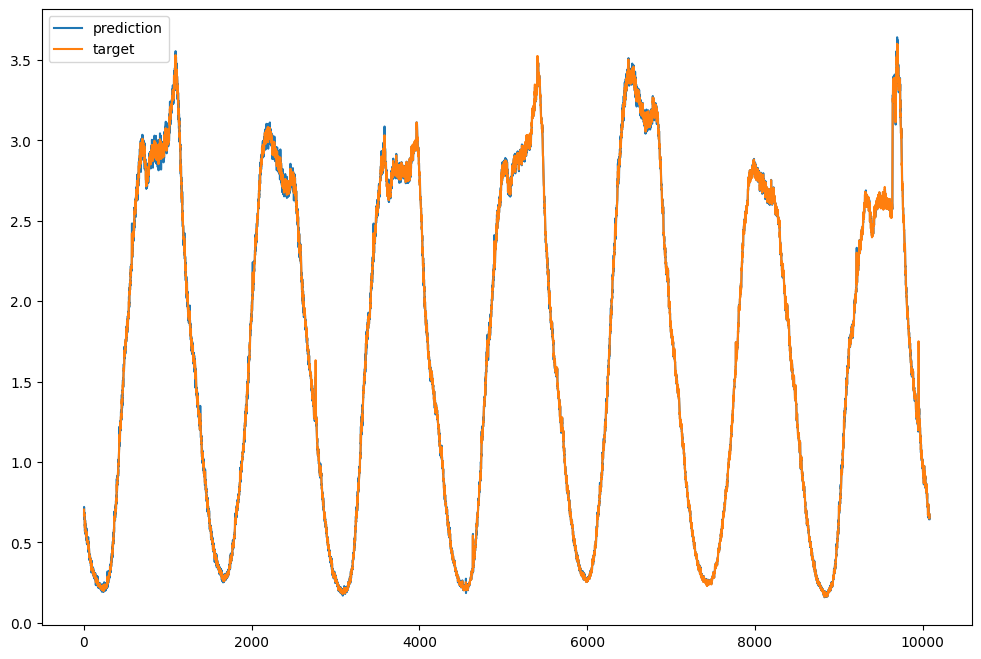

In [20]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [21]:
np.array(pred_list)

array([0.6748811 , 0.72035289, 0.67726016, ..., 0.66212815, 0.67780298,
       0.64463741])

In [22]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[0.704112],
       [0.689872],
       [0.666568],
       ...,
       [0.678984],
       [0.653888],
       [0.649888]])

In [23]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [24]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

SMAPE 1.6535386443138123 %
RMSE 0.02822081930935383
MAPE 1.6549305990338326 %


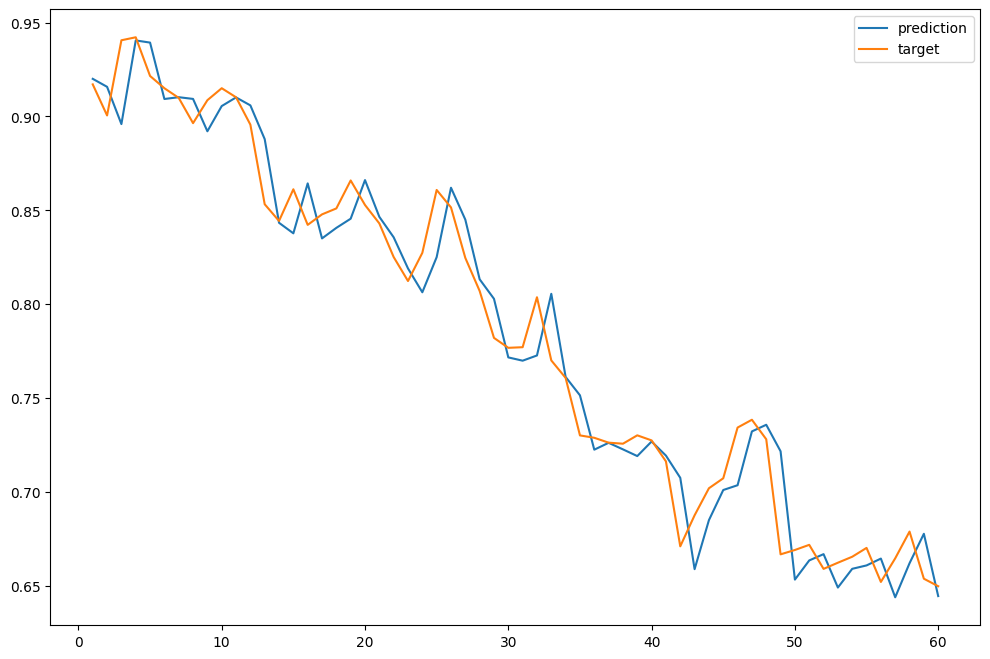

In [25]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

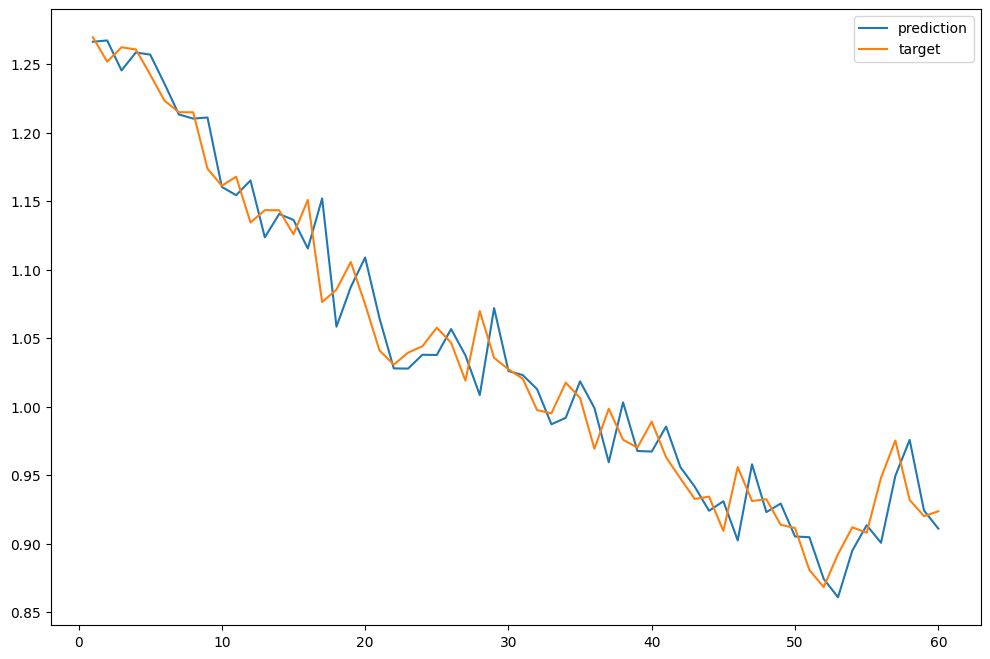

In [26]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [27]:
len(time_list)

10080

In [28]:
np.mean(time_list) 

0.3194523436682565